In [1]:
from graphviz import Digraph
import numpy as np
#from micrograd.engine import Value
import matplotlib.pyplot as plt
import itertools


[[ 5.75581395 -3.72093022]
 [ 5.75581395 -3.72093022]
 [ 5.75581395 -3.72093022]
 [ 5.75581395 -3.72093022]
 [ 5.75581395 -3.72093022]]


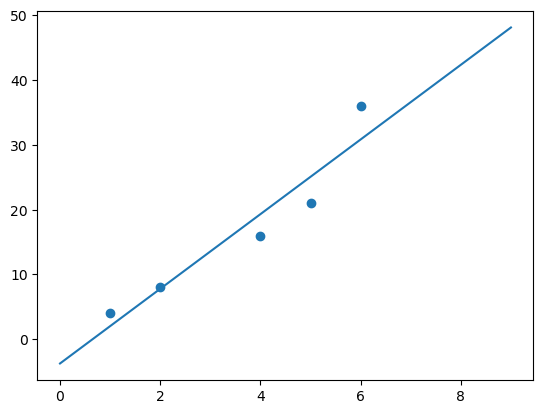

In [11]:
wbs = np.array([[0,0], [0,0], [0,0], [0,0], [0,0]])
data = np.array([[1,4], [2,8], [4,16], [5, 21], [6, 36]])
# y = w_1x + w_0

def predict(weights, input):
    return weights[0][0] * input + weights[0][1]


def cost(y_hats, ys):
    def f(a, b, x):
        return a*x + b

    return sum([np.power(f(y_hat[0], y_hat[1], y[0]) - y[1], 2) for y_hat, y in zip(y_hats, ys)])

def gradient(weights, data=[]):
    def f(a, b, x):
        return a*x + b

    def gradient_w(weights, data):
        return 2*np.sum([(f(y_hat[0], y_hat[1], y[0]) - y[1])*y[0] for y_hat, y in zip(weights, data)])

    def gradient_b(weights, data):
        return 2*np.sum([(f(y_hat[0], y_hat[1], y[0]) - y[1]) for y_hat, y in zip(weights, data)])

    dL_dw = gradient_w(weights, data)
    dL_db = gradient_b(weights, data)

    return dL_dw, dL_db

def update_weights(weights, grad, rate=0.01):
    return np.array([ [w - rate*grad[0], b - rate*grad[1]] for w, b in weights])


cost_collect = []
grad_collect = []

for n in range(1000):
    costs = cost(wbs, data)
    grad = gradient(wbs, data)
    wbs = update_weights(wbs, grad)
    #print(f"Epoch ({n}):\n\tcosts: {costs}")
    #print(f"\tgrad: { 0.01 * np.array(grad)}")
    cost_collect.append(costs)
    grad_collect.append(grad)

#plt.plot(range(len(cost_collect)), cost_collect)
print(wbs)

predictions = [predict(wbs, x) for x in range(100)]
plt.scatter(data[:,0], data[:,1])
plt.plot(range(len(predictions))[:10], predictions[:10])

In [135]:
class Data():
    def __init__(self, f, low=-10, high=10, size=100, seed=42069):
        rng = np.random.default_rng(seed=seed)
        randInts = rng.integers(-10,10, size=size)
        self.data = np.array([(x, f(x) + r) for x, r in zip(range(size), randInts)], dtype=np.float64)

class Weights():
    def __init__(self, size=1, initial='zero', f=lambda a,b,x: a*x + b, learning_rate=0.01, dtype=np.float64):
        self.f = f
        self.learning_rate = learning_rate
        if initial == 'zero':
            self.weights = np.zeros(size, dtype=np.float64)
            self.biases = np.zeros(size, dtype=np.float64)
        elif initial == 'random':
            np.random.seed(42069)
            self.weights = np.random.rand(size)
            self.biases = np.random.rand(size)
        else:
            raise ValueError("Can only initialize with 'zero' or 'random'")
            
    def __repr__(self):
        return f"w=({self.weights}),b=({self.biases})"

    def data(self):
        return np.array([self.weights, self.biases])

    def gradient(self, data):
        
        def grad_w():
            return 2*sum([(self.f(self.weights[0], self.biases[0], x) - y)*x for x,y in data])
        def grad_b():
            return 2*sum([self.f(self.weights[0], self.biases[0], x) - y for x,y in data])

        dL_dw = grad_w()
        dL_db = grad_b()

        return dL_dw, dL_db

    def cost_fn(self, x):
        return self.f(self.weights[0], self.biases[0], x)

    def update(self, grad):
        self.weights = self.weights - self.learning_rate * grad[0]
        self.biases = self.biases - self.learning_rate * grad[1]

    def predict(self, x):
        return self.cost_fn(x)

class SimpleNetwork():
    def __init__(self, weights, data):
        self.weights = weights
        self.data = data

        self.costs_log = []

    def add_cost_to_log(self, cost):
        self.costs_log.append(cost)
    
    def cost(self, data):
        cost = np.array([np.power(self.weights.cost_fn(x) - y, 2) for x,y in data])
        self.add_cost_to_log(cost)
        return cost
    
    def train(self, batch_size=None, epochs=100, quiet=True):
        if batch_size is None:
            batch_size = len(self.data.data)
            
        def bounds_tuples(lower, upper, step):
            return [(l,u) for l,u in zip(range(lower, upper, step), range(lower+step, upper+step, step))]

        for n in range(epochs):
            for lower, upper in bounds_tuples(0, len(self.data.data), batch_size):
                costs = self.cost(self.data.data[lower:upper])
                grad = self.weights.gradient(self.data.data[lower:upper])
                self.weights.update(grad)
            
            if not quiet:
                print(f"Epoch ({n}):\n\tcosts: {costs}")
                print(f"\tgrad: { 0.01 * np.array(grad)}")

w=([399.99790833]),b=([30.9402271])
0.7234354329942131


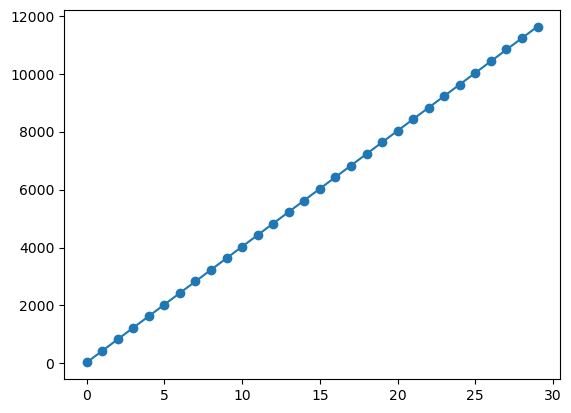

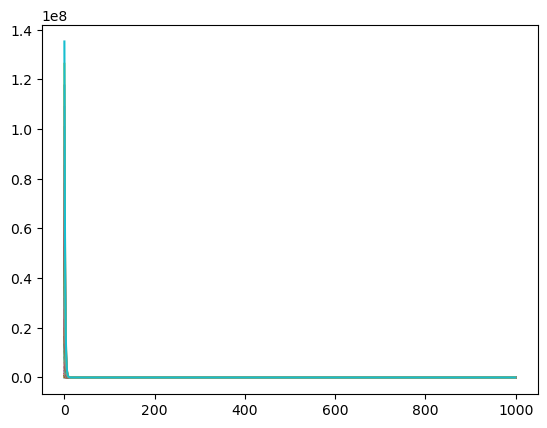

In [144]:
weights = Weights(size=1, initial='zero', learning_rate=0.0001)
data = Data(f=lambda x: 400*x + 32, size=30, seed=12312312312)

network = SimpleNetwork(weights, data)

epochs=1000
network.train(batch_size=30, epochs=epochs)

plt.scatter(data.data[:,0], data.data[:,1])
predictions = [weights.predict(x) for x in data.data[:, 0]]
plt.plot(data.data[:,0], predictions)

error = sum(data.data[:,1] - predictions) / len(predictions)
print(weights)
print(error)

fig = plt.figure()
plt.plot(range(epochs), network.costs_log)